# Import
Importimamo la libreria per la gestione dei files nifti e il pacchetto di supporto custom.

In [1]:
import nii_io as nio
import nii_utils as utils
import nii_settings as nst
import nii_MDV as mdv
import numpy as np
from sklearn.mixture import GMM
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show, axes, sci
from IPython.display import display, Image #Config the matlotlib backend as plotting inline in IPython
%matplotlib inline


# Impostazione dei settaggi di default
Creazione di un file di gestione della computazione.

In [2]:
proj_dir = "."
nii_dir = "./brainNii"
nii_segm_dir = "./brainNii/segmentation"
nii_settings_name = "settings.json"
nii_data_name = "patterns.json"
nii_histogram_name = "histogram.json"
nii_output_dir = "./brainNii/output"

extensions = ['.nii']
patch_side = 3 # considering square pathces

settings = utils.loadDict(proj_dir,nii_settings_name)
if settings == None:
    settings = nst.createSettings(nii_dir,extensions)
utils.saveDict(proj_dir,nii_settings_name,settings)
    
data = utils.loadDict(proj_dir,nii_data_name) # load data 
data = {} if data == None else data

print 'sampled data size'
print '3x3x3 patterns 2 bits per pixel = 54 bits per pattern'
print 'numeber of patter sampled: ' + `len(data.keys())`
print 'total size of pattern sampled: ' + `((len(data.keys())* 54) / 8) /1024` + ' Kbytes'

#print settings

sampled data size
3x3x3 patterns 2 bits per pixel = 54 bits per pattern
numeber of patter sampled: 0
total size of pattern sampled: 0 Kbytes


AD-1.nii


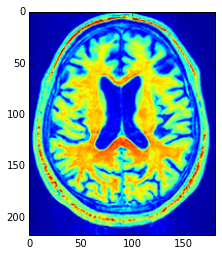

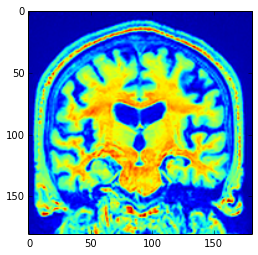

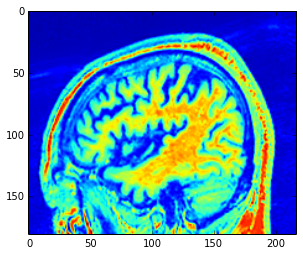

c1AD-1.nii


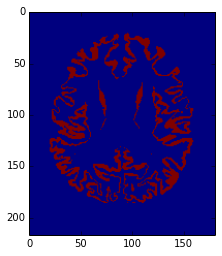

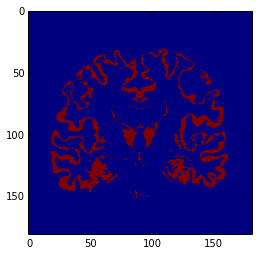

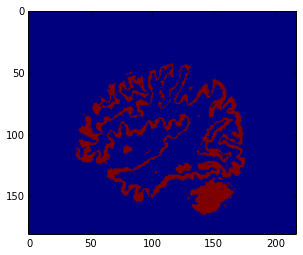

c2AD-1.nii


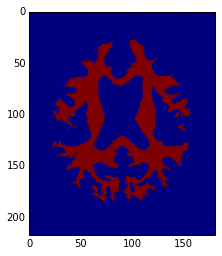

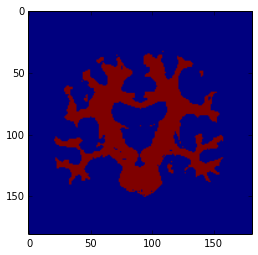

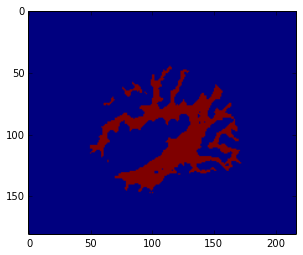

c3AD-1.nii


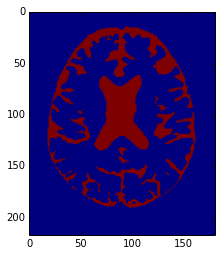

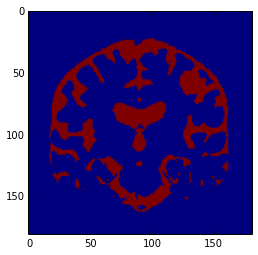

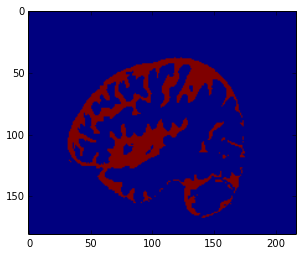

In [3]:
def thrs(t,img):
    shape_ = img.shape
    nuimg = np.array(map(lambda x : 1 if x>t else 0,img.reshape(-1))).reshape(shape_)
    return nuimg

images_meta_data = []
images_data = []
for img_name in sorted(utils.getdirlist(nii_dir,extensions)):
    image_data_and_metadata = (nio.loadNii(utils.joinpath(nii_dir,img_name)))
    image = image_data_and_metadata[2]
    images_meta_data += [(image_data_and_metadata[0],image_data_and_metadata[1])]
    images_data += [image]
    axial = image[int(image.shape[0]/2),:,:] # RL
    coronal = image[:,int(image.shape[1]/2),:] # AP
    saggittal = image[:,:,int(image.shape[2]/4)] # SI
    print img_name
    plt.imshow(axial)
    plt.show()
    plt.imshow(coronal)
    plt.show()
    plt.imshow(saggittal)
    plt.show()
    break

mask_data = []
for img_name in sorted(utils.getdirlist(nii_segm_dir,extensions)):
    image = np.array(nio.loadNii(utils.joinpath(nii_segm_dir,img_name)))[2]
    mask_data += [image]
    axial = image[int(image.shape[0]/2),:,:] # RL
    coronal = image[:,int(image.shape[1]/2),:] # AP
    saggittal = image[:,:,int(image.shape[2]/4)] # SI
    print img_name
    plt.imshow(thrs(0.7,axial))
    plt.show()
    plt.imshow(thrs(0.7,coronal))
    plt.show()
    plt.imshow(thrs(0.7,saggittal))
    plt.show()



In [4]:
tissues_data = [] # 3 arrays containing grey values corresponding to areas in masks

print 'masking: this could take time'
for img in images_data:
    img_unroll = img.reshape(-1)
    tissues = []
    for mask in mask_data:
        hist = []  
        mask_unroll = thrs(0.7,mask.reshape(-1))
        hist = img_unroll * mask_unroll
        hist = [ i for i in hist if i > 0 ]
        tissues += [hist]
    tissues_data += [tissues]
print 'masking: finished'

masking: this could take time
masking: finished


# Reverse engeneerig the segmentation

We assume we have the best threshold values for downsampling.
This thresholds are extracted from sampling values within the masked regions of each tissue.

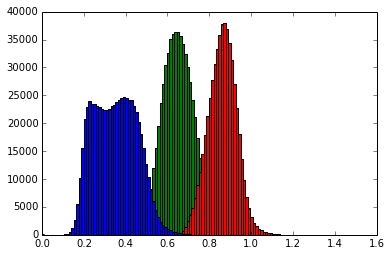

In [5]:
for tissues in tissues_data:
    i = 0
    for tissue in tissues:
        if i == 0:
            plt.hist(tissue, bins=128, range=[0.0, 1.5], color='green')
        if i == 1:
            plt.hist(tissue, bins=128, range=[0.0, 1.5], color='red')
        if i == 2:
            plt.hist(tissue, bins=128, range=[0.0, 1.5], color='blue')
        i+=1
    plt.show()

we notice a mixture of 3 gaussians as expected.

# Recompute EM on single gaussian
In order to get the most representative value for the threshold we recompute the EM estimation from each histogram.

Expectation-maximization algorithm started.
Initialization 1
	EM iteration 1
	EM iteration 2
		EM algorithm converged.


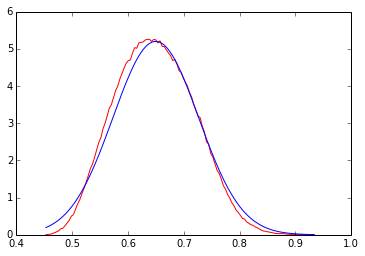

Expectation-maximization algorithm started.
Initialization 1
	EM iteration 1
	EM iteration 2
		EM algorithm converged.


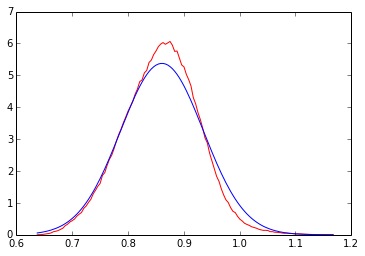

Expectation-maximization algorithm started.
Initialization 1
	EM iteration 1
	EM iteration 2
		EM algorithm converged.


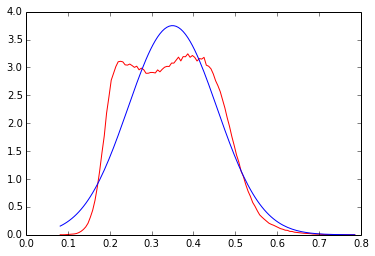

In [6]:
parameters = []
g = GMM(n_components=1,verbose=1)
bins_ = 128
for tissues in tissues_data:
    for tissue in tissues:
        y,x = np.histogram(tissue, bins=bins_, density=True)
        x = x[0:bins_]
        g.fit(np.array(tissue).reshape(-1,1))
        parameters += [g.means_]
        density = np.exp(g.score(x.reshape(-1,1)))
        plt.plot(x[0:bins_], y[0:bins_], '-r')
        plt.plot(x, density, '-b')
        plt.show()
parameters = sorted(parameters)     

now that we have our parameters we'll evenly space the intervals to get the thresholds

[ 0.22498971]
[ 0.4997871]
[ 0.75515419]
[ 1.0303568]


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


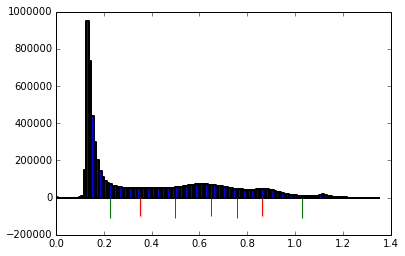

In [7]:
thress = []
min_cut_grey,max_cut_grey =(0.050,1.2)
for img in images_data:
    img_data_voxel = img.reshape(-1)
    plt.hist(img_data_voxel, bins=bins_, color='blue', lw=2)
    for param in parameters:
        plt.vlines(param[0], 0, -100010, color='red')
    for i in range(len(parameters)+1):
        if i == 0:
            thress += [min_cut_grey+parameters[i][0]/float(2)]
        elif i==len(parameters):
            thress += [(parameters[i-1][0]+max_cut_grey)/float(2)]
        else:
            thress += [(parameters[i-1][0]+parameters[i][0])/float(2)]
    for thr in thress:
        print thr
        plt.vlines(thr, 0, -108010, color='green')
    #plt.yscale('log')
    plt.show()

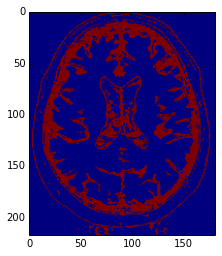

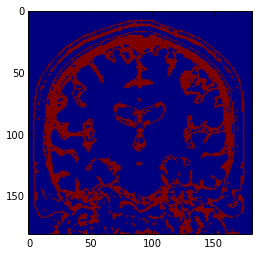

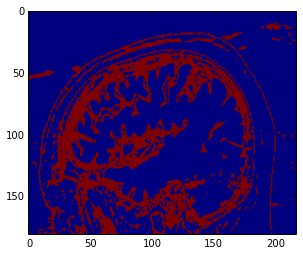

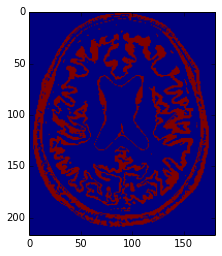

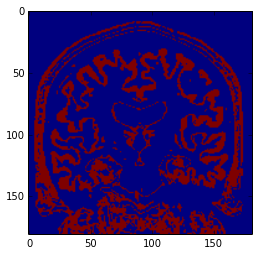

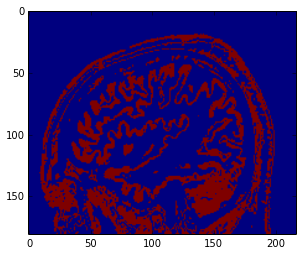

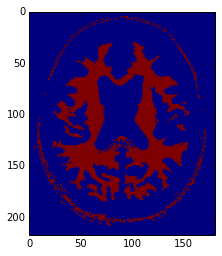

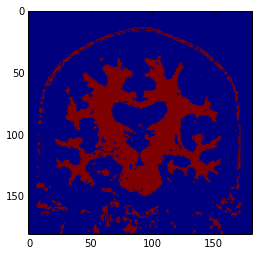

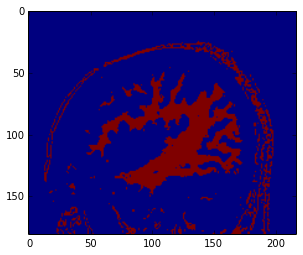

In [8]:
def segment(min_x,max_x,img):
    shape_ = img.shape
    img = img.reshape(-1)
    img = np.array(map(lambda x: 1 if x>=min_x and x<max_x else 0, img))
    return img.reshape(shape_)

c_N_data = []
for img in images_data:
    c_N = []
    c_N += [segment(thress[0],thress[1],img)]
    c_N += [segment(thress[1],thress[2],img)]
    c_N += [segment(thress[2],thress[3],img)]
    c_N_data += [c_N]
    for c_i in c_N:
        axial = c_i[int(c_i.shape[0]/2),:,:] # RL
        coronal = c_i[:,int(c_i.shape[1]/2),:] # AP
        saggittal = c_i[:,:,int(c_i.shape[2]/4)] # SI
        plt.imshow(axial)
        plt.show()
        plt.imshow(coronal)
        plt.show()
        plt.imshow(saggittal)
        plt.show()

# Saving back to nifti

In [11]:
import nii_io as nio
import nii_utils as utils
i = 0
for c_N in c_N_data:
    j = 0
    for c_j in c_N:
        nio.saveNii( utils.joinpath(nii_output_dir,'case_')+`i`+'_'+`j`+'.nii', 
                    images_meta_data[i][0], images_meta_data[i][1], c_j/float(1) )
        j+=1
    i +=1

# code that might be useful! 

In [ ]:
for img_name in utils.getdirlist(nii_dir,extensions):
    images_data = np.array(nio.loadNii(utils.joinpath(nii_dir,img_name)))
    images_data_voxel = images_data.reshape(-1)
    print 'before the cut'
    plt.hist(images_data_voxel, bins=bins_,color='blue', lw=2)
    plt.show()
    print 'after the cut'
    plt.hist([ i for i in images_data_voxel if i > 0.2 ], bins=bins_,color='blue', lw=2)
    plt.yscale('log')
    plt.show()
    break
bins_ = 128
for img_name in utils.getdirlist(nii_dir,extensions):
    images_data = np.array(nio.loadNii(utils.joinpath(nii_dir,img_name)))
    images_data_voxel = images_data.reshape(-1)
    print 'before the cut'
    plt.hist(images_data_voxel, bins=bins_,color='blue', lw=2)
    plt.show()
    print 'after the cut'
    plt.hist([ i for i in images_data_voxel if i > 0.2 ], bins=bins_,color='blue', lw=2)
    plt.yscale('log')
    plt.show()
    break
#mingrey,maxgrey = (np.min(images_data),np.max(images_data))    
#x,bins,desc = plt.hist(images_data, bins=bins_, range=(mingrey, maxgrey), density=True,color='blue', lw=2)
#xpdf = np.linspace(min(x), max(x), bins_)
#np.random.seed(4)
#grey_values = 4
#bins_=128
#g = GMM(n_components=grey_values,verbose=1)
#for img_name in utils.getdirlist(nii_dir,extensions):
#    images_data = np.array(nio.loadNii(utils.joinpath(nii_dir,img_name))).ravel()
#    images_data = np.array([ i for i in images_data if i > 0.2 ])
#    y,x = np.histogram(images_data, bins=bins_, density=True)
#    g.means_ = [0.25,0.45,0.85,0.125]
#    g.fit(images_data.reshape(-1,1),n_iter=100)
#    density = np.exp(g.score(x.reshape(-1,1)))
#    plt.plot(x[0:bins_], y[0:bins_], '-r')
#    plt.plot(x, density, '-b')
#    #plt.yscale('log')
#    plt.show()
#    break


In [82]:
import numpy as np

a = np.array([1,2,3,4])
b = np.array([1,2,3,4])
c = a*b
print c
print c[0:3]

[ 1  4  9 16]
[1 4 9]


In [ ]:
a 